# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.369612
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.381104 analytic: -2.381104, relative error: 4.753724e-09
numerical: -3.929688 analytic: -3.929688, relative error: 1.463066e-08
numerical: -0.986944 analytic: -0.986944, relative error: 8.582509e-09
numerical: 3.012227 analytic: 3.012227, relative error: 2.724001e-08
numerical: 0.403435 analytic: 0.403435, relative error: 6.633683e-09
numerical: 2.033160 analytic: 2.033160, relative error: 1.305114e-08
numerical: 2.117342 analytic: 2.117342, relative error: 7.437090e-09
numerical: 0.384063 analytic: 0.384063, relative error: 1.666172e-08
numerical: -0.698313 analytic: -0.698313, relative error: 6.355525e-08
numerical: 0.356983 analytic: 0.356983, relative error: 1.291578e-08
numerical: 1.331489 analytic: 1.331489, relative error: 6.511806e-09
numerical: 2.393722 analytic: 2.393722, relative error: 6.407577e-09
numerical: -0.952240 analytic: -0.952240, relative error: 3.833282e-08
numerical: -0.923879 analytic: -0.923879, relative error: 5.712278e-08
numerical: 2.028698 an

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.369612e+00 computed in 0.013363s
vectorized loss: 2.369612e+00 computed in 0.006477s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_split = 10
for i in range(num_split):
    for j in range(num_split):
        learning_rate_ij = learning_rates[0] + i*(learning_rates[1]-learning_rates[0])/num_split
        regularization_strengths_ij = regularization_strengths[0] + j*(regularization_strengths[1]-regularization_strengths[0])/num_split
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate_ij, reg=regularization_strengths_ij,
                      num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(learning_rate_ij,regularization_strengths_ij)] = (accuracy_train,accuracy_val)
        
        if accuracy_val > best_val:
            best_val = accuracy_val
            best_softmax = softmax
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 769.426641
iteration 100 / 1500: loss 282.635036
iteration 200 / 1500: loss 104.597452
iteration 300 / 1500: loss 39.667411
iteration 400 / 1500: loss 15.836955
iteration 500 / 1500: loss 7.140228
iteration 600 / 1500: loss 3.875939
iteration 700 / 1500: loss 2.811674
iteration 800 / 1500: loss 2.301405
iteration 900 / 1500: loss 2.142887
iteration 1000 / 1500: loss 2.111433
iteration 1100 / 1500: loss 2.094760
iteration 1200 / 1500: loss 2.103948
iteration 1300 / 1500: loss 2.119964
iteration 1400 / 1500: loss 2.109470
iteration 0 / 1500: loss 844.192364
iteration 100 / 1500: loss 280.562574
iteration 200 / 1500: loss 94.249319
iteration 300 / 1500: loss 32.561380
iteration 400 / 1500: loss 12.192581
iteration 500 / 1500: loss 5.420638
iteration 600 / 1500: loss 3.182032
iteration 700 / 1500: loss 2.506315
iteration 800 / 1500: loss 2.227395
iteration 900 / 1500: loss 2.083812
iteration 1000 / 1500: loss 2.102457
iteration 1100 / 1500: loss 2.104614
iteration 

iteration 1400 / 1500: loss 2.119387
iteration 0 / 1500: loss 1161.136382
iteration 100 / 1500: loss 141.552742
iteration 200 / 1500: loss 18.980463
iteration 300 / 1500: loss 4.215259
iteration 400 / 1500: loss 2.375620
iteration 500 / 1500: loss 2.111437
iteration 600 / 1500: loss 2.111273
iteration 700 / 1500: loss 2.053870
iteration 800 / 1500: loss 2.128160
iteration 900 / 1500: loss 2.132657
iteration 1000 / 1500: loss 2.102310
iteration 1100 / 1500: loss 2.119709
iteration 1200 / 1500: loss 2.092619
iteration 1300 / 1500: loss 2.043748
iteration 1400 / 1500: loss 2.091921
iteration 0 / 1500: loss 1242.325521
iteration 100 / 1500: loss 131.872866
iteration 200 / 1500: loss 15.711655
iteration 300 / 1500: loss 3.559138
iteration 400 / 1500: loss 2.309200
iteration 500 / 1500: loss 2.120278
iteration 600 / 1500: loss 2.097180
iteration 700 / 1500: loss 2.144783
iteration 800 / 1500: loss 2.151560
iteration 900 / 1500: loss 2.074874
iteration 1000 / 1500: loss 2.083273
iteration 110

iteration 1400 / 1500: loss 2.158330
iteration 0 / 1500: loss 776.414745
iteration 100 / 1500: loss 86.227037
iteration 200 / 1500: loss 11.217114
iteration 300 / 1500: loss 3.053039
iteration 400 / 1500: loss 2.205063
iteration 500 / 1500: loss 2.090829
iteration 600 / 1500: loss 2.118144
iteration 700 / 1500: loss 2.079934
iteration 800 / 1500: loss 2.069198
iteration 900 / 1500: loss 2.103460
iteration 1000 / 1500: loss 2.132063
iteration 1100 / 1500: loss 2.105226
iteration 1200 / 1500: loss 2.110385
iteration 1300 / 1500: loss 2.054653
iteration 1400 / 1500: loss 2.053478
iteration 0 / 1500: loss 861.166576
iteration 100 / 1500: loss 76.709377
iteration 200 / 1500: loss 8.589116
iteration 300 / 1500: loss 2.729283
iteration 400 / 1500: loss 2.137122
iteration 500 / 1500: loss 2.096911
iteration 600 / 1500: loss 2.111610
iteration 700 / 1500: loss 2.119080
iteration 800 / 1500: loss 2.101821
iteration 900 / 1500: loss 2.104642
iteration 1000 / 1500: loss 2.136846
iteration 1100 / 1

iteration 1400 / 1500: loss 2.159053
iteration 0 / 1500: loss 1158.508906
iteration 100 / 1500: loss 24.388501
iteration 200 / 1500: loss 2.592440
iteration 300 / 1500: loss 2.155459
iteration 400 / 1500: loss 2.164632
iteration 500 / 1500: loss 2.121752
iteration 600 / 1500: loss 2.050452
iteration 700 / 1500: loss 2.130625
iteration 800 / 1500: loss 2.151687
iteration 900 / 1500: loss 2.109564
iteration 1000 / 1500: loss 2.106984
iteration 1100 / 1500: loss 2.123734
iteration 1200 / 1500: loss 2.048825
iteration 1300 / 1500: loss 2.186413
iteration 1400 / 1500: loss 2.081473
iteration 0 / 1500: loss 1243.199551
iteration 100 / 1500: loss 20.466235
iteration 200 / 1500: loss 2.402629
iteration 300 / 1500: loss 2.117772
iteration 400 / 1500: loss 2.087331
iteration 500 / 1500: loss 2.169810
iteration 600 / 1500: loss 2.066377
iteration 700 / 1500: loss 2.098622
iteration 800 / 1500: loss 2.164067
iteration 900 / 1500: loss 2.162010
iteration 1000 / 1500: loss 2.155294
iteration 1100 / 

iteration 1400 / 1500: loss 2.132487
iteration 0 / 1500: loss 780.834923
iteration 100 / 1500: loss 27.086847
iteration 200 / 1500: loss 2.936084
iteration 300 / 1500: loss 2.158113
iteration 400 / 1500: loss 2.130258
iteration 500 / 1500: loss 2.078379
iteration 600 / 1500: loss 2.058089
iteration 700 / 1500: loss 2.038029
iteration 800 / 1500: loss 2.105492
iteration 900 / 1500: loss 2.119842
iteration 1000 / 1500: loss 2.140061
iteration 1100 / 1500: loss 2.101436
iteration 1200 / 1500: loss 2.021261
iteration 1300 / 1500: loss 2.085792
iteration 1400 / 1500: loss 2.133538
iteration 0 / 1500: loss 857.408035
iteration 100 / 1500: loss 21.415741
iteration 200 / 1500: loss 2.539725
iteration 300 / 1500: loss 2.115418
iteration 400 / 1500: loss 2.078211
iteration 500 / 1500: loss 2.062418
iteration 600 / 1500: loss 2.139356
iteration 700 / 1500: loss 2.100701
iteration 800 / 1500: loss 2.145167
iteration 900 / 1500: loss 2.074699
iteration 1000 / 1500: loss 2.193209
iteration 1100 / 15

iteration 0 / 1500: loss 1157.512849
iteration 100 / 1500: loss 5.671607
iteration 200 / 1500: loss 2.129361
iteration 300 / 1500: loss 2.166019
iteration 400 / 1500: loss 2.115928
iteration 500 / 1500: loss 2.162974
iteration 600 / 1500: loss 2.116418
iteration 700 / 1500: loss 2.124307
iteration 800 / 1500: loss 2.121873
iteration 900 / 1500: loss 2.150941
iteration 1000 / 1500: loss 2.139988
iteration 1100 / 1500: loss 2.106584
iteration 1200 / 1500: loss 2.139887
iteration 1300 / 1500: loss 2.115913
iteration 1400 / 1500: loss 2.123200
iteration 0 / 1500: loss 1254.295048
iteration 100 / 1500: loss 4.735219
iteration 200 / 1500: loss 2.160973
iteration 300 / 1500: loss 2.136001
iteration 400 / 1500: loss 2.159995
iteration 500 / 1500: loss 2.130687
iteration 600 / 1500: loss 2.108718
iteration 700 / 1500: loss 2.115658
iteration 800 / 1500: loss 2.066012
iteration 900 / 1500: loss 2.180174
iteration 1000 / 1500: loss 2.158713
iteration 1100 / 1500: loss 2.148191
iteration 1200 / 15

iteration 100 / 1500: loss 9.288531
iteration 200 / 1500: loss 2.156373
iteration 300 / 1500: loss 2.147477
iteration 400 / 1500: loss 2.132502
iteration 500 / 1500: loss 2.124225
iteration 600 / 1500: loss 2.017063
iteration 700 / 1500: loss 2.116300
iteration 800 / 1500: loss 2.125248
iteration 900 / 1500: loss 2.044547
iteration 1000 / 1500: loss 2.083073
iteration 1100 / 1500: loss 2.106925
iteration 1200 / 1500: loss 2.080369
iteration 1300 / 1500: loss 2.090382
iteration 1400 / 1500: loss 2.098529
iteration 0 / 1500: loss 852.949561
iteration 100 / 1500: loss 7.103953
iteration 200 / 1500: loss 2.172444
iteration 300 / 1500: loss 2.144890
iteration 400 / 1500: loss 2.046897
iteration 500 / 1500: loss 2.068974
iteration 600 / 1500: loss 2.089570
iteration 700 / 1500: loss 2.174367
iteration 800 / 1500: loss 2.109589
iteration 900 / 1500: loss 2.070416
iteration 1000 / 1500: loss 2.066076
iteration 1100 / 1500: loss 2.066445
iteration 1200 / 1500: loss 2.080245
iteration 1300 / 150

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

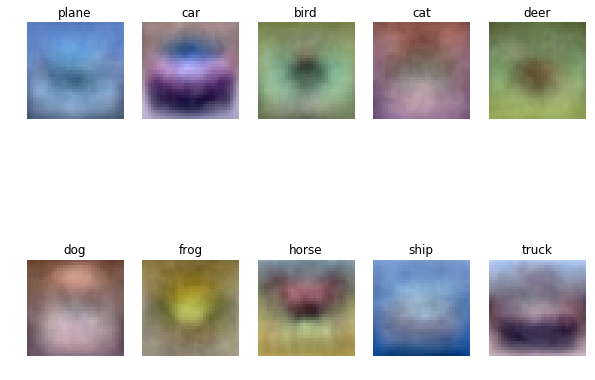

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])